# Primera entrega NBA Salaries

### Integrantes:

- Nicolas Biojo &ensp; A00137580 sis
- Cristian Cobo &ensp;A00348619 sis
- David Erazo &emsp; A00130528 sis   

# Análisis de calidad de los datos

En una primera instancia, se cargaron en un dataframe de pandas el dataset que contiene estadisticas avanzadas del rendiemiento de los jugadores de la NBS durante la temporada 2017-2018. 

In [41]:
import pandas as pd
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

In [99]:
data = pd.read_csv('2017-18_NBA_salary.csv')
data.head()

,Player,Salary,NBA_Country,NBA_DraftNumber,Age,Tm,G,MP,PER,TS%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Zhou Qi,815615,China,43,22,HOU,16,87,0.6,0.303,...,18.2,19.5,-0.4,0.1,-0.2,-0.121,-10.6,0.5,-10.1,-0.2
1,Zaza Pachulia,3477600,Georgia,42,33,GSW,66,937,16.8,0.608,...,19.3,17.2,1.7,1.4,3.1,0.160,-0.6,1.3,0.8,0.7
2,Zach Randolph,12307692,USA,19,36,SAC,59,1508,17.3,0.529,...,12.5,27.6,0.3,1.1,1.4,0.046,-0.6,-1.3,-1.9,0.0
3,Zach LaVine,3202217,USA,13,22,CHI,24,656,14.6,0.499,...,9.7,29.5,-0.1,0.5,0.4,0.027,-0.7,-2.0,-2.6,-0.1
4,Zach Collins,3057240,USA,10,20,POR,62,979,8.2,0.487,...,15.6,15.5,-0.4,1.2,0.8,0.038,-3.7,0.9,-2.9,-0.2


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 28 columns):
Player             485 non-null object
Salary             485 non-null int64
NBA_Country        485 non-null object
NBA_DraftNumber    485 non-null int64
Age                485 non-null int64
Tm                 485 non-null object
G                  485 non-null int64
MP                 485 non-null int64
PER                485 non-null float64
TS%                483 non-null float64
3PAr               483 non-null float64
FTr                483 non-null float64
ORB%               485 non-null float64
DRB%               485 non-null float64
TRB%               485 non-null float64
AST%               485 non-null float64
STL%               485 non-null float64
BLK%               485 non-null float64
TOV%               483 non-null float64
USG%               485 non-null float64
OWS                485 non-null float64
DWS                485 non-null float64
WS                 485 non-n

Previo al análisis, se identificaron las variables cuantitativas y categoricas apartir del método .info(). Adicionalmente, este método nos permitió evidenciar la existencia de missing values a partir del número de registros por variable, los cuales fueron: TS%, 3PAr, FTr y TOV% en los registros 29 y 37.

### Búsqueda de valores nulos

In [26]:
mColums = pd.isnull(data).any(0).to_numpy().nonzero()[0]
print("Missing values: ")
for col in mColums:
    print ("  index {} name {}".format(col,data.columns[col]))

Missing values: 
  index 9 name TS%
  index 10 name 3PAr
  index 11 name FTr
  index 18 name TOV%


In [27]:
index = pd.isnull(data).any(1).to_numpy().nonzero()[0]
print("{} incomplete records:".format(len(index)), index)

2 incomplete records: [29 37]


In [28]:
originalData = data.copy()
data = data.dropna()
print("Datos originales: ", originalData.shape)
print("Datos limpios y completos: ", data.shape)
print("Se eliminaron {} registos".format(originalData.shape[0] - data.shape[0]))

Datos originales:  (485, 28)
Datos limpios y completos:  (483, 28)
Se eliminaron 2 registos


### Análisis de variables relevantes

Acontinuación, se lleva acabo un análisis sobre las variables de mayor relevancia para identificar inconsistencias o datos erronoes. 

- Player: Podemos ver que existen jugadores en varios equipos. En este caso el jugador Kay Felder se encuentra en los equipos: DET,CHI y TOT.
- NBA_Country: No existen dos o más labels distintos para representar un mismo país.
- Age: No existe ningun jugador el cual sea menor de 18 años.
- Salary: Todos los pagos a los jugadores son valores positivos.
- TS%: Se logra identificar un posible dato erroneo el cual determina un 150%. 
- G: Todas las cantidades de partidos jugados son valores positivos.
- MP: Todos los valores referentes a los minutos jugados son valores positivos.
- OWS: Los valores referentes al número estimado de victorias por un desempeño ofensivo presenta valores positivos como                negativos, donde suponemos que los negativos representan las derrotas. 
- DWS: Los valores referentes al número estimado de victorias por un desempeño defensivo presenta valores positivos
- WS: Los valores referentes al número estimado de victorias contribuidas por un jugador, presenta valores positivos como             negativos, donde suponemos que los negativos representan las derrotas. 

Busqueda de jugadores en más de un equipo 

In [29]:
data.describe()

,Salary,NBA_DraftNumber,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
count,4.830000e+02,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,...,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000
mean,6.660622e+06,29.395445,26.273292,50.370600,1158.915114,13.315735,0.535387,0.337383,0.263404,4.893996,...,13.140373,18.975569,1.280745,1.181366,2.465424,0.080325,-1.252588,-0.489441,-1.741822,0.601242
std,7.398214e+06,21.116033,4.274290,24.723561,809.627553,8.745666,0.112352,0.226894,0.294578,4.581519,...,6.115290,5.826533,1.883545,1.033939,2.674520,0.163229,5.028752,2.394156,5.665905,1.247636
min,4.608000e+04,1.000000,19.000000,1.000000,1.000000,-41.100000,0.000000,0.000000,0.000000,0.000000,...,0.000000,5.700000,-2.300000,0.000000,-1.200000,-1.063000,-36.500000,-14.300000,-49.200000,-1.300000
25%,1.471382e+06,10.500000,23.000000,29.500000,385.000000,9.800000,0.505500,0.167000,0.155000,1.800000,...,9.900000,15.000000,0.000000,0.300000,0.300000,0.040500,-2.600000,-1.700000,-3.500000,-0.100000
50%,3.218280e+06,25.000000,26.000000,59.000000,1151.000000,13.200000,0.545000,0.346000,0.231000,3.300000,...,12.500000,17.900000,0.800000,1.000000,1.900000,0.083000,-1.100000,-0.400000,-1.300000,0.100000
75%,1.000000e+07,47.000000,29.000000,71.000000,1824.500000,16.550000,0.582500,0.481000,0.319500,7.050000,...,15.750000,22.250000,2.000000,1.800000,3.600000,0.123000,0.400000,1.000000,0.550000,0.900000
max,3.468255e+07,62.000000,41.000000,79.000000,2898.000000,134.100000,1.500000,1.000000,5.333000,35.900000,...,66.700000,45.100000,11.400000,5.600000,15.000000,2.713000,68.700000,6.800000,54.400000,8.600000


In [30]:
data["NBA_Country"].unique()

array(['China', 'Georgia', 'USA', 'Canada', 'Spain', 'France',
       'Czech Republic', 'Russia', 'South Sudan', 'Switzerland',
       'New Zealand', 'Haiti', 'Democratic Re_', 'Tunisia', 'Brazil',
       'Germany', 'Australia', 'Cameroon', 'Israel', 'Turkey',
       'United Kingdo...', 'Montenegro', 'Serbia', 'Argentina', 'Bosnia',
       'Lithuania', 'Croatia', 'Italy', 'Poland', 'Dominican Rep...',
       'Finland', 'Latvia', 'Bosnia & Herz...', 'Sweden', 'Ukraine',
       'Austria', 'Puerto Rico', 'Senegal', 'Slovenia', 'Greece',
       'Democratic Re...', 'Mali', 'Bahamas', 'Egypt'], dtype=object)

In [31]:
print ("Menores de edad: {}".format(data.loc[data.Age < 18].shape[0]))

Menores de edad: 0


In [32]:
playersNba = data.iloc[:,0]
boolPlayersDuplicated = playersNba.duplicated()

i = 0
for x in boolPlayersDuplicated: 
    i +=1
    if(x == True):
        print(data.iloc[lambda m: m.index  == i].Player)
   


224    Kay Felder
Name: Player, dtype: object
225    Kay Felder
Name: Player, dtype: object


# Visualización de datos

En la siguiente matriz de correlación podemos identificar las relaciones entre todas las variables, donde los slots más claros representan un valor porcentaul de relación más alto. Mientras que los slots más oscuros representan una relación inversamente proporcional entre las variables. 


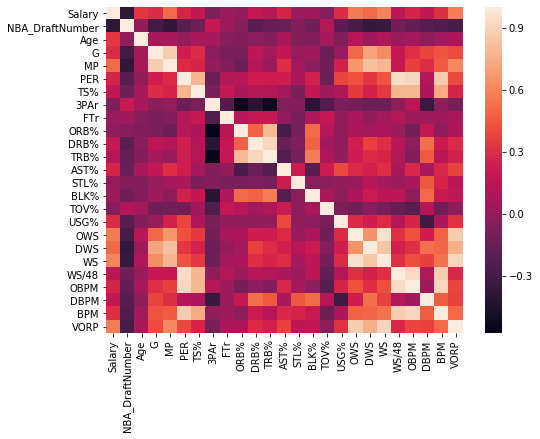

<Figure size 7200x4320 with 0 Axes>

In [33]:
fig = plt.figure(figsize=(8,6))
corrMatrix = data.corr()
sn.heatmap(corrMatrix, annot=False)
plt.figure(figsize=(100,60))
plt.show()

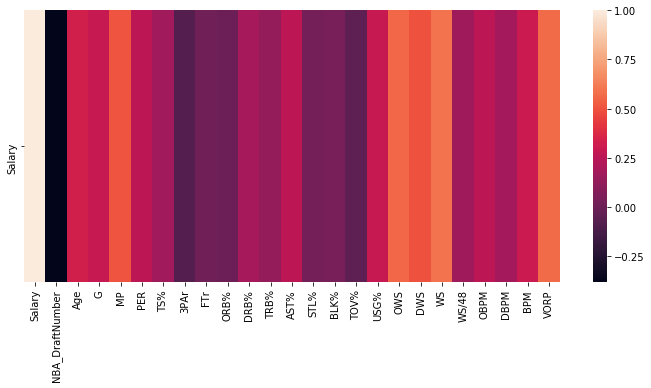

In [34]:
fig = plt.figure(figsize=(12,5))
sn.heatmap(corrMatrix[:1], annot=False)
plt.show()

Para evaluar la relación entre el salario de los jugadores y el resto de variables, realizamos la siguiente matriz de correlación, la cual nos permitio identificar las variables que están más relacionadas con esta:


- MP: Minutos jugados

- OWS: Offensive Win Shares (número estimado de victorias contribuidas por un jugador dado su desempeño ofensivo)

- DWS: Defensive Win Shares (número estimado de victorias contribuidas por un jugador dado su desempeño defensivo)

- WS: Win Shares (número estimado de victorias contribuidas por un jugador)

- VORP: Value Over Replacement Player (métrica para medir la contribución total de un jugador al equipo)



## Análsis diagrama de Cajas y Bigotes

A continuación, por cada una de las variables que seleccionamos, las representamos por medio de diagramas de caja para poder observar la distribución de cada una de estas. 

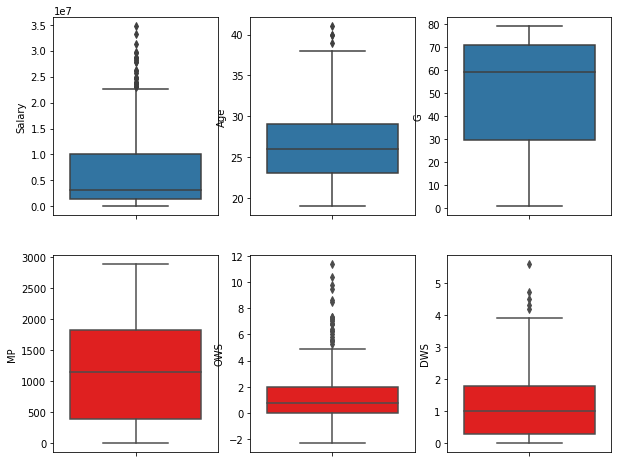

In [35]:
fig = plt.figure(figsize=(10,8))

plt.subplot(2,3,1)
sn.boxplot('Salary', data=data, orient='v')

plt.subplot(2,3,2)
sn.boxplot('Age', data=data, orient='v')

plt.subplot(2,3,3)
sn.boxplot('G', data=data, orient='v')

plt.subplot(2,3,4)
sn.boxplot('MP', data=data, orient='v', color="r")

plt.subplot(2,3,5)
sn.boxplot('OWS', data=data, orient='v', color="r")

plt.subplot(2,3,6)
sn.boxplot('DWS', data=data, orient='v', color="r")

- Como se puede obsevar en el anterior diagrama de cajas y bigotes de la variable "Salary" al menos el 50% de los jugadores gana en promedio entre 0.25 y 0.3 millones de dolares.

- En cuanto se refiere a la variable "Age" se puede afirmar que, al menos el 50% de los jugadores tienen una edad entre 26 y 27 años. Además tambien se puede decir que al menos el 75% de los jugadores tienen una edad menor a 30 años. 

- Si observamos el diagrama de cajas de la variable "G"(No. de partidos jugados) podemos ver que al menos el 50% de los jugadores de la temporada NBA 2017-2018 jugaron aproxidamente 60 partidos. Y al menos el 25% de estos jugadores tuvieron aproximadamente el 30 partidos. 

- Ahora bien, si analizamos el grafico de la variable "MP"(Minutos jugados) podemos ver que este particular se diferencia de los demás puesto a aque su sesgo tiende a ser simétrico. Tambien se puede decir que al menos el 50% de los jugadores de la temporada 18-17 de la NBA  ha jugado aproximadamente 1200 minutos. Y al menos el 75% ha jugado entre 1800 y 1900 minutos.

- En el diagrama de cajas de la variable "OWS" (Número estimado de victorias contribuidas por un jugador dado su desempeño ofensivo) se puede ver que existe una gran cantidad de datos atípicos. Estos puntos atípicos representan alto número de vitorias dado al buen desempeño ofensivo de ese jugador. 

- El diagrama de caja de la variable "DWS" al igual que lz variable "OWS" tambien tiende a tener sesgo negativo. Y al menos el 50% de los jugadores cuentan con un puntaje de 1 para esta variable.







## Análisis de Histogramas 
### Distribuciones: Salary, Age y Mp(Minutos jugados)

Text(0.5, 1.0, 'MP')

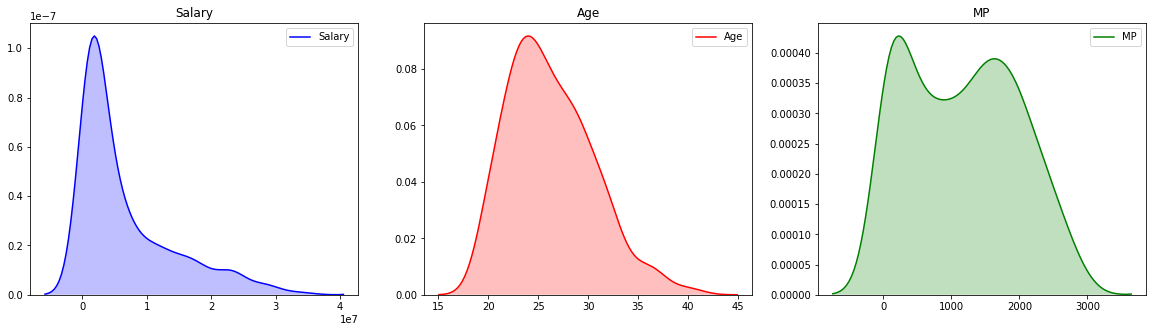

In [36]:
fig = plt.figure(figsize=(20,5))

d = data.iloc[:,1]
plt.subplot(1,3,1)
ax = sn.kdeplot(d, shade=True, color="b")
ax.set_title("Salary")

d = data.iloc[:,4]
plt.subplot(1,3,2)
ax = sn.kdeplot(d, shade=True, color="r")
ax.set_title("Age")

d = data.iloc[:,7]
plt.subplot(1,3,3)
ax = sn.kdeplot(d, shade=True, color="g")
ax.set_title("MP")


- Gráfico 1: La variable "Salary" tiende a tener una distribución Chi - Cuadrada
- Gráfico 2: La variable "Age" tiende a tener una distribución Normal
- Gráfico 3: La varivale "Mp" (Minutos jugados) tiende a tener una distribución Bimodal. 

# Limpieza de datos

La limpieza de datos es un proceso necesario para asegurar la calidad de los datos. Este paso es muy importante para minimizar el error al basarnos en información poco precisa, errónea o incompleta.

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 483 entries, 0 to 484
Data columns (total 28 columns):
Player             483 non-null object
Salary             483 non-null int64
NBA_Country        483 non-null object
NBA_DraftNumber    483 non-null int64
Age                483 non-null int64
Tm                 483 non-null object
G                  483 non-null int64
MP                 483 non-null int64
PER                483 non-null float64
TS%                483 non-null float64
3PAr               483 non-null float64
FTr                483 non-null float64
ORB%               483 non-null float64
DRB%               483 non-null float64
TRB%               483 non-null float64
AST%               483 non-null float64
STL%               483 non-null float64
BLK%               483 non-null float64
TOV%               483 non-null float64
USG%               483 non-null float64
OWS                483 non-null float64
DWS                483 non-null float64
WS                 483 non-n

In [38]:
data['Player']=data['Player'].astype('category')
data['NBA_Country']=data['NBA_Country'].astype('category')
data['Tm']=data['Tm'].astype('category')
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 483 entries, 0 to 484
Data columns (total 28 columns):
Player             483 non-null category
Salary             483 non-null int64
NBA_Country        483 non-null category
NBA_DraftNumber    483 non-null int64
Age                483 non-null int64
Tm                 483 non-null category
G                  483 non-null int64
MP                 483 non-null int64
PER                483 non-null float64
TS%                483 non-null float64
3PAr               483 non-null float64
FTr                483 non-null float64
ORB%               483 non-null float64
DRB%               483 non-null float64
TRB%               483 non-null float64
AST%               483 non-null float64
STL%               483 non-null float64
BLK%               483 non-null float64
TOV%               483 non-null float64
USG%               483 non-null float64
OWS                483 non-null float64
DWS                483 non-null float64
WS                 483

Para las variables Player, NBA_Country y Tm se les modificó el tipo de variable object a categorica, ya que esto facilita la ejecución de los modelos.

In [39]:
data.mean()

Salary             6.660622e+06
NBA_DraftNumber    2.939545e+01
Age                2.627329e+01
G                  5.037060e+01
MP                 1.158915e+03
PER                1.331573e+01
TS%                5.353872e-01
3PAr               3.373830e-01
FTr                2.634037e-01
ORB%               4.893996e+00
DRB%               1.501263e+01
TRB%               9.949275e+00
AST%               1.300145e+01
STL%               1.535818e+00
BLK%               1.720290e+00
TOV%               1.314037e+01
USG%               1.897557e+01
OWS                1.280745e+00
DWS                1.181366e+00
WS                 2.465424e+00
WS/48              8.032505e-02
OBPM              -1.252588e+00
DBPM              -4.894410e-01
BPM               -1.741822e+00
VORP               6.012422e-01
dtype: float64

In [40]:
data.var()

Salary             5.473358e+13
NBA_DraftNumber    4.458869e+02
Age                1.826955e+01
G                  6.112545e+02
MP                 6.554968e+05
PER                7.648668e+01
TS%                1.262289e-02
3PAr               5.148085e-02
FTr                8.677598e-02
ORB%               2.099032e+01
DRB%               4.615189e+01
TRB%               2.425914e+01
AST%               8.268201e+01
STL%               9.735484e-01
BLK%               2.834691e+00
TOV%               3.739677e+01
USG%               3.394849e+01
OWS                3.547741e+00
DWS                1.069030e+00
WS                 7.153055e+00
WS/48              2.664372e-02
OBPM               2.528835e+01
DBPM               5.731984e+00
BPM                3.210248e+01
VORP               1.556596e+00
dtype: float64

In [101]:
stdsc = StandardScaler()
headers_to_normalize = ['Salary', 'NBA_DraftNumber', 'Age','G','MP', 'PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','OBPM','DBPM','BPM','VORP']
    
x= data[headers_to_normalize].values
x_scaled = stdsc.fit_transform(x)
data_t = pd.DataFrame(x_scaled, columns=headers_to_normalize, index=data.index)
data[headers_to_normalize] = data_t

Se realizó la normalización de los datos con el fin de lograr identificar datos atípicos de una manera más sencilla, puesto que de no ser así, se tendría que hacer un trajabo exautivo sobre cada variable.

In [102]:
data.head()

,Player,Salary,NBA_Country,NBA_DraftNumber,Age,Tm,G,MP,PER,TS%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Zhou Qi,-0.788207,China,0.641986,-0.999069,HOU,-1.374973,-1.316613,-1.445261,-2.070536,...,0.828231,0.101557,-0.891440,-1.041588,-0.994139,-0.121,-1.858018,0.414552,-1.474606,-0.641902
1,Zaza Pachulia,-0.427748,Georgia,0.594602,1.578317,GSW,0.637163,-0.267905,0.404005,0.646970,...,1.008295,-0.286013,0.225877,0.216258,0.241394,0.160,0.133581,0.749718,0.452685,0.081356
2,Zach Randolph,0.767935,USA,-0.495241,2.281240,SAC,0.355464,0.436581,0.461081,-0.056909,...,-0.104825,1.466478,-0.519001,-0.074014,-0.395093,0.046,0.133581,-0.339571,-0.024718,-0.481178
3,Zach LaVine,-0.465037,USA,-0.779547,-0.999069,CHI,-1.053032,-0.614595,0.152870,-0.324204,...,-0.563169,1.786645,-0.731823,-0.654559,-0.769497,0.027,0.113665,-0.632841,-0.148489,-0.561540
4,Zach Collins,-0.484669,USA,-0.921701,-1.467685,POR,0.476192,-0.216086,-0.577704,-0.431123,...,0.402626,-0.572478,-0.891440,0.022743,-0.619735,0.038,-0.483815,0.582135,-0.201533,-0.641902


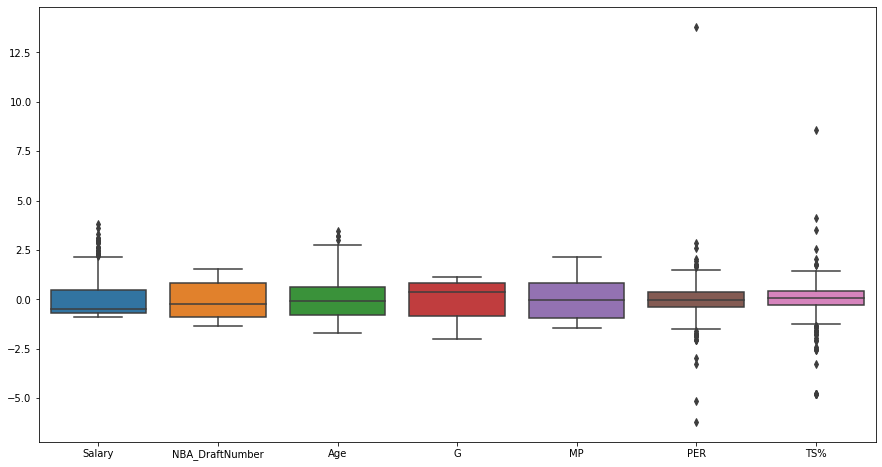

In [103]:
plt.rc('figure',figsize=(15,8))
sn.boxplot( orient= "v", data=data[headers_to_normalize[0:7]])

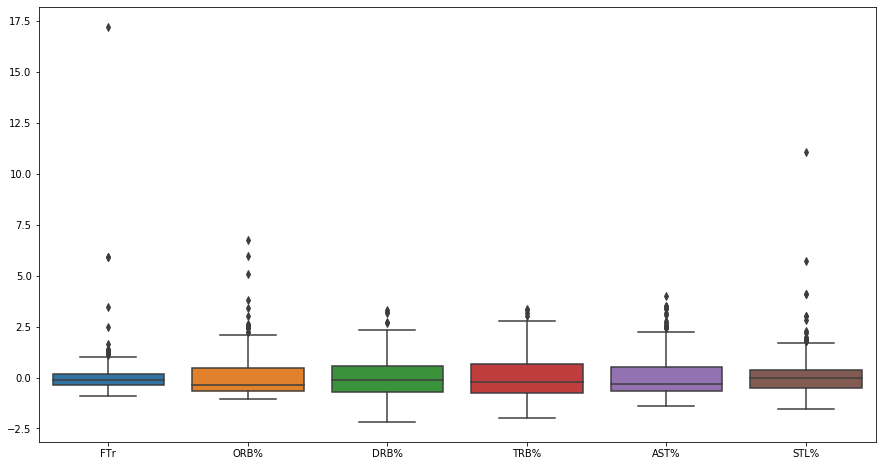

In [87]:
sn.boxplot( orient= "v", data=data[headers_to_normalize[8:14]])


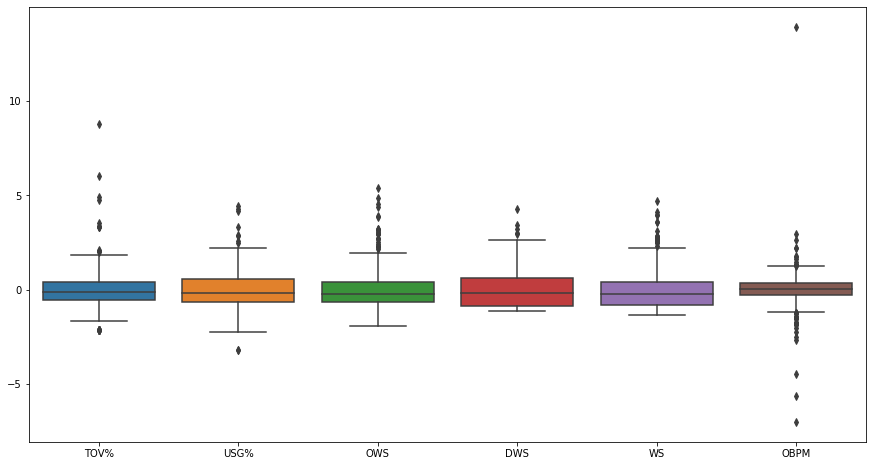

In [88]:
sn.boxplot( orient= "v", data=data[headers_to_normalize[15:21]])

Luego de haber normalizado los datos y de su posterior visualización en diagrama de cajas, se logra identificar que la mayoria de datos atípicos se encuentran por fuera del rango de -5 a 5 desviaciones estandar. Por lo tanto se obta

In [94]:
for header in headers_to_normalize:
    print(header+":",len(data[abs(data[header])>(data[header].mean()+5)]))
    data.drop(data[abs(data[header])>(data[header].mean()+5)].index,inplace=True)


Salary: 0
NBA_DraftNumber: 0
Age: 0
G: 0
MP: 0
PER: 3
TS%: 0
3PAr: 0
FTr: 3
ORB%: 2
DRB%: 0
TRB%: 0
AST%: 0
STL%: 2
BLK%: 0
TOV%: 2
USG%: 0
OWS: 1
DWS: 0
WS: 0
OBPM: 0
DBPM: 0
BPM: 0
VORP: 2


In [95]:
for header in headers_to_normalize:
    print(header+":",len(data[abs(data[header])>(data[header].mean()+5)]))

Salary: 0
NBA_DraftNumber: 0
Age: 0
G: 0
MP: 0
PER: 0
TS%: 0
3PAr: 0
FTr: 0
ORB%: 0
DRB%: 0
TRB%: 0
AST%: 0
STL%: 0
BLK%: 0
TOV%: 0
USG%: 0
OWS: 0
DWS: 0
WS: 0
OBPM: 0
DBPM: 0
BPM: 0
VORP: 0
